In [65]:
import csv
import numpy as np
import pandas as pd

In [66]:
train_X = pd.read_csv("Train_X.csv")
train_X.head(10)

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_Encoded
0,9350545,48,16,0,0,0,12,14,33
1,5867312,43,1,0,2,0,1,13,18
2,998868,44,16,0,0,0,5,13,31
3,3455137,56,19,0,0,0,12,11,16
4,2754687,30,3,0,0,0,3,11,48
5,5911008,75,18,0,0,0,6,10,27
6,1969474,65,12,0,0,0,12,12,49
7,618333,37,19,0,0,1,6,10,39
8,8693354,69,9,0,1,0,6,12,43
9,6905894,39,8,0,0,1,7,11,31


In [67]:
train_Y = pd.read_csv("Train_Y.csv")
train_Y.head(10)

,Risk_Flag
0,0
1,0
2,1
3,1
4,0
5,1
6,1
7,0
8,0
9,0


## Making a node

In [68]:
class Node():
    def __init__(self,feature_index = None, threshold=None , left = None , right = None,info_gain = None , value=None):
    
        # for making decision
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node 
        self.value = value
        

## Tree class

In [69]:
import numpy as np

class DecisionTreeClassifier():
    def __init__(self, min_samples_split=3, max_depth=3):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, features_to_use, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, features_to_use)
            
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], features_to_use, curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], features_to_use, curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, features_to_use):
        ''' function to find the best split '''
            
        best_split ={}
        max_info_gain = -float("inf")
        best_split["info_gain"] = max_info_gain
        
        for feature_index in features_to_use:
            
            # Extract feature values from the dataset
            feature_values = dataset[:, feature_index]
            # Calculate the number of unique feature values
            num_unique_values = len(np.unique(feature_values))
            # If number of unique feature values is more than 100, choose 100 randomly, else choose all
            if num_unique_values > 100:
                # Randomly select 100 unique feature values from the dataset
                possible_thresholds = np.unique(np.random.choice(feature_values, size=100, replace=False))
            else:
                # Use all unique feature values
                possible_thresholds = np.unique(feature_values)
            
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y, features_to_use):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset, features_to_use)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)


In [70]:
import random
def bootstrap_feature(num_of_feature,num):
    # Generate 3 non-repetitive random numbers from 0 to 5
    random_numbers = random.sample(range(num_of_feature),  int(num) )
    return random_numbers


In [71]:
def bootstrap_sample(x, y, num_samples):
    # Ensure x and y have the same number of samples
    assert len(x) == len(y), "x and y must have the same number of samples"

    # Get the number of samples in x
    num_samples_total = len(x)

    # Generate random indices for the bootstrap sample
    indices = np.random.choice(num_samples_total, size=num_samples, replace=True)

    # Use the indices to select samples from x and y
    x_new = x.iloc[indices]  # Use iloc for DataFrame indexing
    y_new = y.iloc[indices]  # Use iloc for DataFrame indexing

    return x_new, y_new

In [72]:
def balance_data2(x_file, y_file):
    # Read the data from the files
    X = pd.read_csv(x_file)
    y = pd.read_csv(y_file)

    # Get indices for each class
    indices_0 = y[y['Risk_Flag'] == 0].index
    indices_1 = y[y['Risk_Flag'] == 1].index

    # Sample the indices for each class
    min_samples = min(len(indices_0), len(indices_1))
    sampled_indices = np.concatenate([
        np.random.choice(indices_0, min_samples, replace=False),
        np.random.choice(indices_1, min_samples, replace=False)
    ])

    # Get the corresponding X and y values
    X_balanced = X.loc[sampled_indices]
    y_balanced = y.loc[sampled_indices]

    # Reset index
    X_balanced.reset_index(drop=True, inplace=True)
    y_balanced.reset_index(drop=True, inplace=True)


    return X_balanced, y_balanced


In [73]:
X_train,Y_train = balance_data2("Train_X.csv","Train_Y.csv")

In [74]:
X_train

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_Encoded
0,1969474,65,12,0,0,0,12,12,49
1,4275801,78,8,1,0,1,3,11,42
2,1752625,41,8,0,0,0,3,10,26
3,456398,74,17,0,0,1,7,14,39
4,3111365,46,14,0,0,0,8,10,23
...,...,...,...,...,...,...,...,...,...
31393,2929735,23,14,0,0,0,9,12,31
31394,1988524,50,6,0,0,0,6,13,24
31395,670260,70,16,0,0,0,14,14,46
31396,355672,47,11,0,0,0,11,14,45


In [75]:
Y_train

,Risk_Flag
0,0
1,0
2,0
3,0
4,0
...,...
31393,1
31394,1
31395,1
31396,1


In [76]:
for column in X_train.columns:
    value_counts = X_train[column].value_counts()
    print(f"Value counts for column '{column}':")
    print(value_counts)
    print()

Value counts for column 'Income':
1362373    32
2499018    31
700444     30
10675      29
2362103    29
           ..
7754322     1
4389550     1
9448702     1
8735153     1
1666981     1
Name: Income, Length: 12644, dtype: int64

Value counts for column 'Age':
33    727
54    725
76    680
35    632
48    626
66    622
47    616
27    615
50    609
45    608
26    593
24    585
25    584
23    584
60    580
41    571
59    568
78    564
72    563
69    558
56    557
30    554
70    549
22    549
37    532
39    521
64    517
46    517
61    514
29    514
40    513
79    512
62    510
53    510
42    509
71    504
21    501
74    493
58    492
55    491
57    490
32    487
38    487
75    485
77    484
34    483
63    483
28    478
44    477
68    473
43    467
73    466
51    458
49    456
31    453
36    442
67    441
65    430
52    389
Name: Age, dtype: int64

Value counts for column 'Experience':
15    1627
5     1624
9     1605
16    1605
6     1594
1     1581
3     1576
19    15

Correlation Matrix:


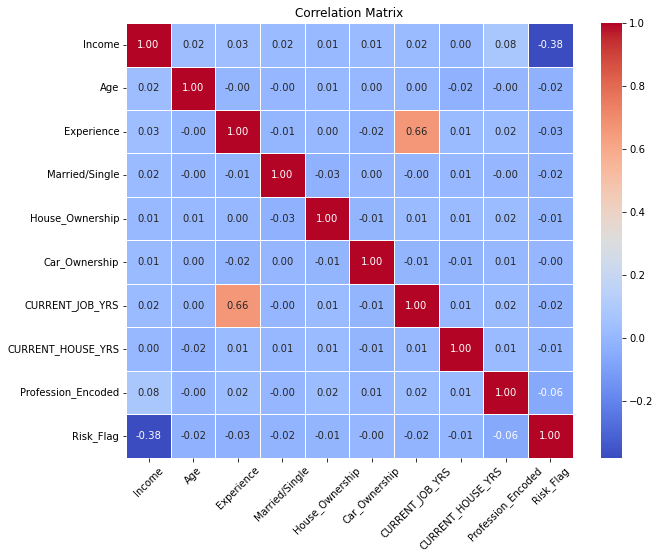

In [77]:
df = pd.concat([X_train, Y_train], axis=1)

# Calculate correlation matrix
correlation_matrix = df.corr()

print("Correlation Matrix:")
#print(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_matrix is the correlation matrix calculated earlier

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [78]:
Y_train

,Risk_Flag
0,0
1,0
2,0
3,0
4,0
...,...
31393,1
31394,1
31395,1
31396,1


In [79]:
# Assuming Y_test is your numpy array
unique_values, value_counts = np.unique(Y_train, return_counts=True)
value_counts_dict = dict(zip(unique_values, value_counts))
print("Value counts in Y_train:", value_counts_dict)

Value counts in Y_train: {0: 15699, 1: 15699}


## testing data

In [80]:
def balance_data1(x_test_file, y_test_file):
    # Read the test data from files
    x_test = pd.read_csv(x_test_file)
    y_test = pd.read_csv(y_test_file)
    
    # Find the indices of 0s and 1s in y_test
    indices_0 = np.where(y_test == 0)[0]
    indices_1 = np.where(y_test == 1)[0]
    
    # Sample an equal number of instances for each class
    min_samples = min(len(indices_0), len(indices_1))
    sampled_indices_0 = np.random.choice(indices_0, min_samples, replace=False)
    sampled_indices_1 = np.random.choice(indices_1, min_samples, replace=False)
    
    # Concatenate the sampled indices
    sampled_indices = np.concatenate([sampled_indices_0, sampled_indices_1])
    
    # Get corresponding x_test and y_test values
    balanced_x_test = x_test.iloc[sampled_indices]
    balanced_y_test = y_test.iloc[sampled_indices]
    
    # Convert to numpy arrays
    balanced_x_test = balanced_x_test.to_numpy()
    balanced_y_test = balanced_y_test.to_numpy().flatten()  # Flatten to 1D array
    
    return balanced_x_test, balanced_y_test


In [81]:
X_test,Y_test = balance_data1('test_x.csv','test_y.csv')

In [82]:
X_test = pd.read_csv("test_x.csv")
Y_test = pd.read_csv("test_y.csv")

In [83]:
X_test.shape

(3491, 9)

In [84]:
X_test = X_test.to_numpy()
Y_test=Y_test.to_numpy().flatten()  

In [85]:
X_test

array([[5452004,      44,       7, ...,       4,      10,      10],
       [6535026,      79,      18, ...,      12,      11,      22],
       [4004948,      59,       7, ...,       7,      12,      47],
       ...,
       [ 116617,      62,      15, ...,      14,      11,      23],
       [1198023,      44,       7, ...,       3,      12,      29],
       [9569607,      51,      13, ...,      12,      13,       6]],
      dtype=int64)

In [86]:
print(X_test.shape)
print(Y_test.size)

(3491, 9)
3491


In [87]:
X_train

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Profession_Encoded
0,1969474,65,12,0,0,0,12,12,49
1,4275801,78,8,1,0,1,3,11,42
2,1752625,41,8,0,0,0,3,10,26
3,456398,74,17,0,0,1,7,14,39
4,3111365,46,14,0,0,0,8,10,23
...,...,...,...,...,...,...,...,...,...
31393,2929735,23,14,0,0,0,9,12,31
31394,1988524,50,6,0,0,0,6,13,24
31395,670260,70,16,0,0,0,14,14,46
31396,355672,47,11,0,0,0,11,14,45


In [88]:

# Assuming Y_test is your numpy array
unique_values, value_counts = np.unique(Y_test, return_counts=True)
value_counts_dict = dict(zip(unique_values, value_counts))
print("Value counts in Y_test:", value_counts_dict)

Value counts in Y_test: {0: 1753, 1: 1738}


In [89]:
tree = int(input("enter number of tress :- "))
Y_pred = np.zeros(X_test.shape[0]) 

for i in range(tree):

    X_train1 , Y_train1 = bootstrap_sample(X_train,Y_train,10000)
    features_to_use = bootstrap_feature(X_train.shape[1],int(X_train.shape[1]*0.6))
    classifier = DecisionTreeClassifier(min_samples_split=50, max_depth=3)
    classifier.fit(X_train1,Y_train1,features_to_use)

    print("tree ",i ," :- \n")
    #classifier.print_tree()
    #print("\n\n")
    
    Y_pred_iteration = np.array(classifier.predict(X_test))
    Y_pred = np.sum([Y_pred, Y_pred_iteration], axis=0) if i > 0 else Y_pred_iteration



enter number of tress :- 10
tree  0  :- 

tree  1  :- 

tree  2  :- 

tree  3  :- 

tree  4  :- 

tree  5  :- 

tree  6  :- 

tree  7  :- 

tree  8  :- 

tree  9  :- 



In [90]:
Y_predicted = np.where(Y_pred >= float(float(tree)/2.0), 1, 0)

In [91]:
unique_values, value_counts = np.unique(Y_predicted, return_counts=True)
value_counts_dict = dict(zip(unique_values, value_counts))
print("Value counts in Y_predicted:", value_counts_dict)

Value counts in Y_predicted: {0: 1453, 1: 2038}


In [92]:
Y_pred 

array([1, 1, 3, ..., 7, 6, 4], dtype=int64)

67.80292179891148
Confusion Matrix:
[[1041  712]
 [ 412 1326]]


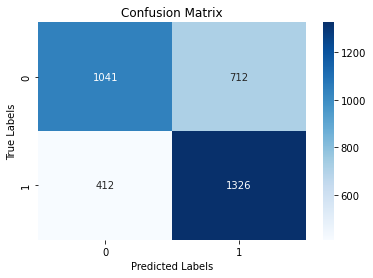

F1 Score: 0.7023305084745763


In [93]:

from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, Y_predicted)*100)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_predicted)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import f1_score

# Assuming y_true and y_pred are the true and predicted labels, respectively
# For example:
# y_true = [0, 1, 1, 0, 1]
# y_pred = [0, 1, 0, 0, 1]

# Calculate the F1 score
f1 = f1_score(Y_test, Y_predicted)

print("F1 Score:", f1)


In [96]:
cnt0 = 0
cnt1 = 0
for i in range(len(Y_test)):
    if Y_test[i] != Y_predicted[i]:
        print("answer = ",Y_test[i]," and Y_pred = ", Y_predicted[i], Y_pred[i] )
        if Y_test[i] == 0:
            cnt0 += 1
        else:
            cnt1 += 1
        
print("when original is 0 = ",cnt0," and when original is 1 = ",cnt1)
        

answer =  1  and Y_pred =  0 1
answer =  1  and Y_pred =  0 3
answer =  0  and Y_pred =  1 8
answer =  0  and Y_pred =  1 5
answer =  1  and Y_pred =  0 3
answer =  1  and Y_pred =  0 3
answer =  0  and Y_pred =  1 7
answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 6
answer =  1  and Y_pred =  0 1
answer =  0  and Y_pred =  1 7
answer =  1  and Y_pred =  0 4
answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 5
answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 6
answer =  0  and Y_pred =  1 7
answer =  0  and Y_pred =  1 5
answer =  1  and Y_pred =  0 1
answer =  1  and Y_pred =  0 2
answer =  0  and Y_pred =  1 7
answer =  1  and Y_pred =  0 1
answer =  0  and Y_pred =  1 8
answer =  0  and Y_pred =  1 5
answer =  0  and Y_pred =  1 7
answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 8
answer =  0  and Y_pred =  1 8
answer =  1  and Y_pred =  0 4
answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 10
answer =  0  and Y_pred =  1 7
answer 

answer =  0  and Y_pred =  1 8
answer =  0  and Y_pred =  1 7
answer =  1  and Y_pred =  0 3
answer =  0  and Y_pred =  1 5
answer =  0  and Y_pred =  1 8
answer =  1  and Y_pred =  0 1
answer =  0  and Y_pred =  1 7
answer =  0  and Y_pred =  1 7
answer =  0  and Y_pred =  1 5
answer =  0  and Y_pred =  1 5
answer =  1  and Y_pred =  0 1
answer =  1  and Y_pred =  0 2
answer =  0  and Y_pred =  1 5
answer =  1  and Y_pred =  0 2
answer =  0  and Y_pred =  1 6
answer =  0  and Y_pred =  1 9
answer =  1  and Y_pred =  0 1
answer =  0  and Y_pred =  1 5
answer =  1  and Y_pred =  0 1
answer =  0  and Y_pred =  1 6
answer =  1  and Y_pred =  0 3
answer =  1  and Y_pred =  0 2
answer =  0  and Y_pred =  1 5
answer =  0  and Y_pred =  1 6
answer =  0  and Y_pred =  1 10
answer =  1  and Y_pred =  0 4
answer =  1  and Y_pred =  0 3
answer =  1  and Y_pred =  0 2
answer =  1  and Y_pred =  0 0
answer =  1  and Y_pred =  0 4
answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 10
answer

answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 8
answer =  0  and Y_pred =  1 9
answer =  1  and Y_pred =  0 2
answer =  0  and Y_pred =  1 7
answer =  0  and Y_pred =  1 9
answer =  0  and Y_pred =  1 6
answer =  1  and Y_pred =  0 3
answer =  0  and Y_pred =  1 6
answer =  0  and Y_pred =  1 10
answer =  1  and Y_pred =  0 0
answer =  1  and Y_pred =  0 3
answer =  1  and Y_pred =  0 4
answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 6
answer =  1  and Y_pred =  0 2
answer =  0  and Y_pred =  1 5
answer =  0  and Y_pred =  1 6
answer =  0  and Y_pred =  1 9
answer =  0  and Y_pred =  1 8
answer =  1  and Y_pred =  0 4
answer =  0  and Y_pred =  1 9
answer =  0  and Y_pred =  1 6
answer =  1  and Y_pred =  0 2
answer =  0  and Y_pred =  1 6
answer =  0  and Y_pred =  1 7
answer =  1  and Y_pred =  0 1
answer =  0  and Y_pred =  1 7
answer =  1  and Y_pred =  0 2
answer =  0  and Y_pred =  1 5
answer =  1  and Y_pred =  0 3
answer =  1  and Y_pred =  0 4
answer 